## Imports

In [1]:
import pandas as pd
import os
import re
from collections import Counter
import time
import csv
import base64
import sys
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix as sparse
import spacy

## Paths

In [2]:
data_dir = 'C:\\Users\\obarn\\Projects\\F-MT126-1\\vilio\\data'
feature_dir = os.path.join(data_dir, 'features')
anno_dir = os.path.join(feature_dir, 'annotations')
gt_dir = os.path.join(anno_dir, 'gt')
img_dir = os.path.join(feature_dir, 'img')

## Load Annotations

In [18]:
train = pd.read_json(os.path.join(gt_dir, "train.jsonl"), lines=True, orient="records")
traindev = pd.read_json(os.path.join(anno_dir, "traindev.jsonl"), lines=True, orient="records")
dev_seen = pd.read_json(os.path.join(gt_dir, "dev_seen.jsonl"), lines=True, orient="records")
dev_unseen = pd.read_json(os.path.join(gt_dir, "dev_unseen.jsonl"), lines=True, orient="records")
dev = pd.read_json(os.path.join(gt_dir, "dev_all.jsonl"), lines=True, orient="records")
test_seen = pd.read_json(os.path.join(gt_dir, "test_seen.jsonl"), lines=True, orient="records")
test_unseen = pd.read_json(os.path.join(gt_dir, "test_unseen.jsonl"), lines=True, orient="records")
test = test_seen.append(test_unseen)

## Load Image Features

In [19]:
#csv.field_size_limit(sys.maxsize)
FIELDNAMES = ["img_id", "img_h", "img_w", "objects_id", "objects_conf",
              "attrs_id", "attrs_conf", "num_boxes", "boxes", "features"]
    
def load_obj_tsv(fname, ids, topk=None):
    """Load object features from tsv file.
    :param fname: The path to the tsv file.
    :param topk: Only load features for top K images (lines) in the tsv file.
        Will load all the features if topk is either -1 or None.
    :return: A list of image object features where each feature is a dict.
        See FIELDNAMES above for the keys in the feature dit.
    """
    data = []
    start_time = time.time()
    print("Start to load Faster-RCNN detected objects from %s" % fname)
    with open(fname) as f:
        reader = csv.DictReader(f, FIELDNAMES, delimiter="\t")
        boxes = 36 # args.num_features  # Same boxes for all

        for i, item in enumerate(reader):

            # Check if id in list of ids to save memory
            if int(item["img_id"]) not in ids:
                continue

            for key in ['img_h', 'img_w', 'num_boxes']:
                item[key] = int(item[key])

            boxes = item['num_boxes']
            decode_config = [
                ('objects_id', (boxes,), np.int64),
                ('objects_conf', (boxes,), np.float32),
                ('attrs_id', (boxes,), np.int64),
                ('attrs_conf', (boxes,), np.float32),
                ('boxes', (boxes, 4), np.float32),
                ('features', (boxes, -1), np.float32),
            ]
            for key, shape, dtype in decode_config:
                item[key] = np.frombuffer(base64.b64decode(item[key]), dtype=dtype)
                try:
                    item[key] = item[key].reshape(shape)
                except:
                    # In 1 out of 10K cases, the shape comes out wrong; We make necessary adjustments
                    shape = list(shape)
                    shape[0] += 1
                    shape = tuple(shape)
                    item[key] = item[key].reshape(shape)

                item[key].setflags(write=False)

            data.append(item)
            if topk is not None and len(data) == topk:
                break
    elapsed_time = time.time() - start_time
    print("Loaded %d images in file %s in %d seconds." % (len(data), fname, elapsed_time))
    return data

In [20]:
# Load VG Classes
vg_path = 'C:\\Users\\obarn\\Projects\\F-MT126-1\\vilio\\features\\vilio\\py-bottom-up-attention\\demo\\data\\genome\\1600-400-20'

vg_classes = []
with open(os.path.join(vg_path, 'objects_vocab.txt')) as f:
    for object in f.readlines():
        vg_classes.append(object.split(',')[0].lower().strip())
        
vg_attrs = []
with open(os.path.join(vg_path, 'attributes_vocab.txt')) as f:
    for object in f.readlines():
        vg_attrs.append(object.split(',')[0].lower().strip())

In [223]:
features = os.path.join(feature_dir, '10ac.tsv')

# Loading detection features to img_data
ids = [int(file.split('.')[0]) for file in os.listdir(img_dir)]
img_data = load_obj_tsv(features, ids, topk=-1)

# Convert img list to dict
imgid2img = {}
for img_datum in img_data:
    # Adding int here to convert 0625 to 625
    imgid2img[int(img_datum['img_id'])] = img_datum

Start to load Faster-RCNN detected objects from C:\Users\obarn\Projects\F-MT126-1\vilio\data\features\10ac.tsv
Loaded 12140 images in file C:\Users\obarn\Projects\F-MT126-1\vilio\data\features\10ac.tsv in 30 seconds.


In [234]:
for img in imgid2img.keys():
    imgid2img[img]['objects'] = list(map(lambda x: vg_classes[x], imgid2img[img]['objects_id']))
    imgid2img[img]['attrs'] = list(map(lambda x: vg_attrs[x], imgid2img[img]['attrs_id']))

## Metrics

In [237]:
def analyse(name, split):
    print(f'########## {name} #########')
    length = len(split)
    num_hateful = split.label.value_counts()[1]
    print(f'{length} memes')
    print(f'{num_hateful} ({num_hateful/length:.2f}) hateful')
    print(f'{length - num_hateful} ({1-num_hateful/length:.2f}) not hateful')
    print()

In [238]:
analyse('train', train)
analyse('dev_seen', dev_seen)
analyse('dev_unseen', dev_unseen)
analyse('dev', dev)
analyse('test_seen', test_seen)
analyse('test_unseen', test_unseen)
analyse('test', test)

########## train #########
8500 memes
3019 (0.36) hateful
5481 (0.64) not hateful

########## dev_seen #########
500 memes
247 (0.49) hateful
253 (0.51) not hateful

########## dev_unseen #########
540 memes
200 (0.37) hateful
340 (0.63) not hateful

########## dev #########
640 memes
247 (0.39) hateful
393 (0.61) not hateful

########## test_seen #########
1000 memes
490 (0.49) hateful
510 (0.51) not hateful

########## test_unseen #########
2000 memes
750 (0.38) hateful
1250 (0.62) not hateful

########## test #########
3000 memes
1240 (0.41) hateful
1760 (0.59) not hateful



## Topic Analysis

### Build Dataset

In [239]:
nlp = spacy.load("en_core_web_sm")
def clean_text(text):
    cleaned = []
    doc = nlp(text)
    for token in doc:
        if not token.is_stop and token.text.isalnum():
            cleaned.append(token.text)
    return cleaned

In [240]:
def split_text(text):
    new_text = text.split(' ') 
    return [word for word in new_text if len(word) != 0]

In [258]:
dataset = dev
#dataset = dataset[dataset['label']==0]
words = pd.DataFrame({'id': dataset.id, 'text': dataset.text})
words['text'] = words.text.apply(lambda x: re.sub("[^\w']", " ",  x))
#words['text'] = words.text.apply(clean_text)
words['objects'] = [imgid2img[img]['objects'] for img in words.id]
words['attrs'] = [imgid2img[img]['attrs'] for img in words.id]
words['words'] = words['attrs'] #words.objects words.text #* 4 + weighted concatenation of text and image features
all_text = words.words.sum()
vocab = list(set(all_text))
words['words'] = words.words.apply(lambda x: Counter(x))
counts = words.words.sum()

In [259]:
tot = len(all_text)
vocab_prob = []
for k,v in counts.items():
    vocab_prob.append((k, v / tot))

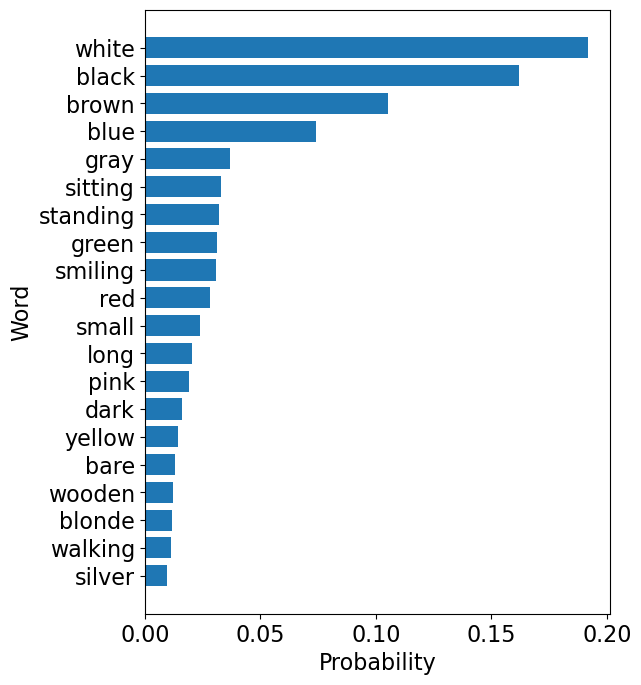

In [260]:
sorted_vocab_prob = sorted(vocab_prob, key = lambda x: x[1], reverse=True)[:20]
labels, probs = list(zip(*sorted_vocab_prob))
yy = np.linspace(0, 20, 20)
plt.figure(figsize=(6,8), dpi=100)
plt.barh(-yy, probs);
plt.yticks(-yy, labels=labels, fontsize=16);
plt.xticks(fontsize=16);
plt.xlabel('Probability', fontsize=16);
plt.ylabel('Word', fontsize=16);
plt.locator_params(axis='x', nbins=7)

### LDA

In [27]:
A = []
for idx, row in tqdm(words.iterrows()):
    for w in row.words.keys():
        A.append([idx, vocab.index(w), row.words[w]])
A = np.array(A)

9092it [00:11, 770.03it/s]


In [28]:
def sampleDiscrete(p, ran=None):
    """
    Helper method for sampling from an unnormalized discrete random variable using (generalized) inverse CDF sampling
    :param p: probability mass function over {0,...,num_values-1}
    :return: x \in {0,...,num_values-1} a sample drawn according to p
    """
    normalization_constant = np.sum(p)
    uniform_number = ran or np.random.rand()
    r = uniform_number * normalization_constant
    a = p[0]
    i = 0
    while a < r:
        i += 1
        a += p[i]
    return i

In [29]:
K = 5
alpha = 0.1
gamma = 0.1

W = len(vocab)      # total number of unique words
D = dataset.shape[0]  # number of memes

# A's columns are doc_id, word_id, count
swd = sparse((A[:, 2], (A[:, 1], A[:, 0]))).tocsr()

# Initialization
skd = np.zeros((K, D))  # count of word assignments to topics for document d
swk = np.zeros((W, K))  # unique word topic assignment counts across all documents

s = []  # each element of the list corresponds to a document
r = 0
for d in range(D):  # iterate over the documents
    z = np.zeros((W, K))  # unique word topic assignment counts for doc d
    words_in_doc_d = A[np.where(A[:, 0] == d), 1][0]
    for w in words_in_doc_d:  # loop over the unique words in doc d
        c = swd[w, d]  # number of occurrences for doc d
        for i in range(c):  # assign each occurrence of word w to a doc at random
            k = np.floor(K*np.random.rand())
            z[w, int(k)] += 1
            r += 1
    skd[:, d] = np.sum(z, axis=0)  # number of words in doc d assigned to each topic
    swk += z  # unique word topic assignment counts across all documents
    s.append(sparse(z))  # sparse representation: z contains many zero entries

sk = np.sum(skd, axis=1)  # word to topic assignment counts accross all documents
# This makes a number of Gibbs sampling sweeps through all docs and words, it may take a bit to run
num_gibbs_iters = 50
theta_history = np.zeros((D, num_gibbs_iters, K))
beta_history = np.zeros((num_gibbs_iters, W, K))
for iter in tqdm(range(num_gibbs_iters)):
    for d in range(D):
        z = s[d].todense()  # unique word topic assigmnet counts for document d
        words_in_doc_d = A[np.where(A[:, 0] == d), 1][0] 
        for w in words_in_doc_d:  # loop over unique words in doc d
            a = z[w, :].copy()  # number of times word w is assigned to each topic in doc d
            indices = np.where(a > 0)[1]  # topics with non-zero word counts for word w in doc d
            np.random.shuffle(indices)
            for k in indices:  # loop over topics in permuted order
                k = int(k)
                for i in range(int(a[0, k])):  # loop over counts for topic k
                    z[w, k] -= 1  # remove word from count matrices
                    swk[w, k] -= 1
                    sk[k] -= 1
                    skd[k, d] -= 1
                    b = (alpha + skd[:, d]) * (gamma + swk[w, :]) \
                        / (W * gamma + sk)
                    kk = sampleDiscrete(b, np.random.rand())  # Gibbs sample new topic assignment
                    z[w, kk] += 1  # add word with new topic to count matrices
                    swk[w, kk] += 1
                    sk[kk] += 1
                    skd[kk, d] += 1

        s[d] = sparse(z)  # store back into sparse structure
        
        theta = ( skd[:, d] + alpha ) / np.sum(skd[:, d] + alpha)
        theta_history[d, iter, :] = theta
    beta = ( swk + gamma ) / np.sum(swk + gamma, axis=0)
    beta_history[iter] = beta

100%|██████████| 50/50 [11:02<00:00, 13.26s/it]


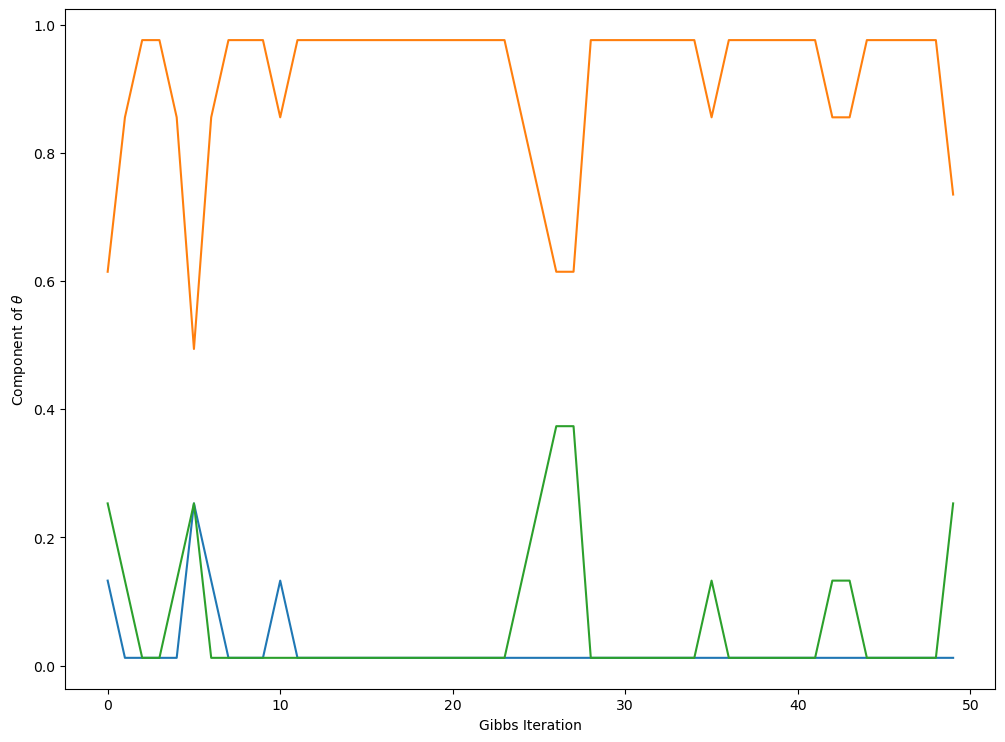

In [105]:
plt.figure(figsize=(12,9), dpi=100)
plt.plot(theta_history[13,:,:]);
plt.xlabel('Gibbs Iteration');
plt.ylabel('Component of $\\theta$');

In [38]:
k = 2
topic = zip(vocab, beta[:, k])
topic = sorted(topic, key = lambda x: x[1], reverse=True)[:20]
topic

[('man', 0.027961057768778323),
 ('hair', 0.017965996701799904),
 ('woman', 0.012909868657867772),
 ('wall', 0.012809415782822763),
 ('hand', 0.011302622657147625),
 ('shirt', 0.010750131844400074),
 ('table', 0.009209854427043265),
 ('people', 0.008992206531112412),
 ('head', 0.008741074343499888),
 ('eye', 0.0073347340928697595),
 ('face', 0.006614821821713859),
 ('border', 0.006598079675873025),
 ('fuck', 0.006531111092509685),
 ('sky', 0.006464142509146346),
 ('new', 0.006028846717284639),
 ('window', 0.005911651696398795),
 ('building', 0.00589490955055796),
 ('like', 0.005794456675512951),
 ('gas', 0.004907122945948702),
 ('time', 0.004538795737450335)]

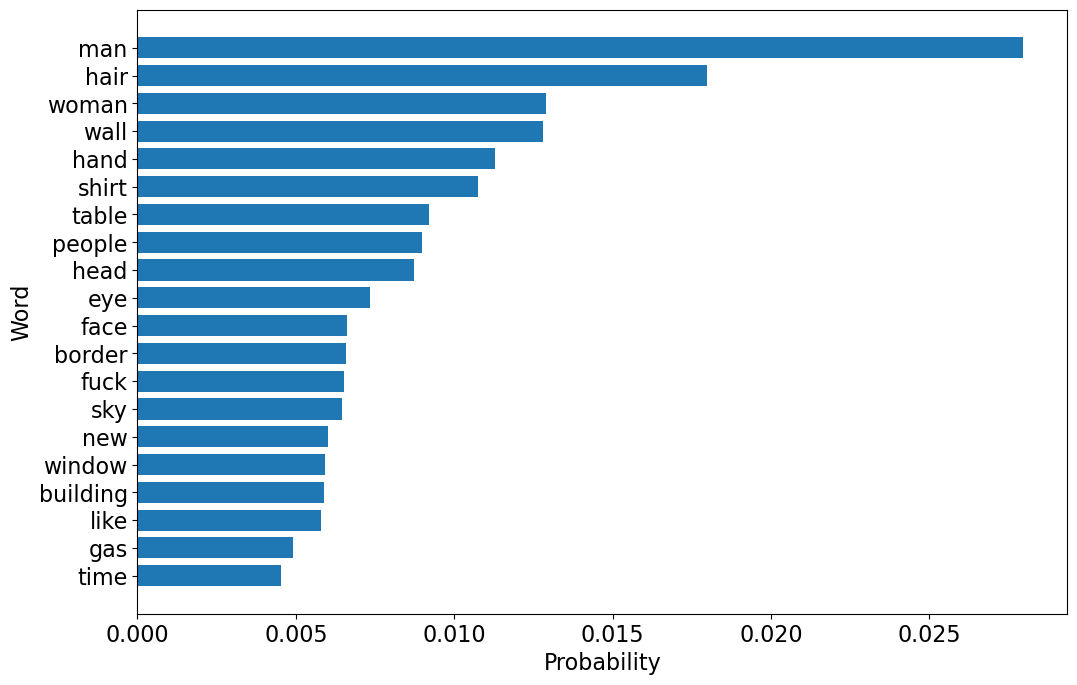

In [47]:
labels, probs = list(zip(*topic))
yy = np.linspace(0, 20, 20)
plt.figure(figsize=(12,8), dpi=100)
plt.barh(-yy, probs);
plt.yticks(-yy, labels=labels, fontsize=16);
plt.xticks(fontsize=16);
plt.xlabel('Probability', fontsize=16);
plt.ylabel('Word', fontsize=16);